Import MDAnalysis Module (https://www.mdanalysis.org/) and Matplotlib <br/> 
Don't forget to add the permissions: <br/>
sudo jupyter-nbextension enable nglview --py --sys-prefix <br/>
sudo  jupyter-nbextension enable --py widgetsnbextension <br/>

In [1]:
%matplotlib nbagg
%matplotlib inline
import MDAnalysis as mda
import MDAnalysis.analysis.leaflet
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nglview as nv

import warnings
warnings.filterwarnings('ignore')

pi = np.pi

In [2]:
# name and files for the simulation studied LPT - no GM1

name = '_DPPC_DIPC_chol_352'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2/sans_GM1/'
path_res = '/users/cornet/Documents/PhD/Matthieu/3-5-2/sans_GM1/line_tension/'

fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

# name and files for the simulation studied LPT - 5% GM1

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2_extended/5_GM1/'
path_res = '/users/cornet/Documents/PhD/Matthieu/3-5-2_extended/5_GM1/line_tension/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_20micros_mb_fixed_t1_ref19999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_20micros_mb_fixed_t1.xtc'

# name and files for the simulation studied LPT - 10% GM1

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2_extended/10_GM1/traj/'
path_res = '/users/cornet/Documents/PhD/Matthieu/3-5-2_extended/10_GM1/line_tension/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_10_43nm_20micros_mb_fixed_t1_ref19999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_10_43nm_20micros_mb_fixed_t1.xtc'

Load xtc and gro files using mda.Universe('struct file','traj file')

In [3]:
u = mda.Universe( path+fgro, path+fxtc)

In [4]:
sel_all = u.select_atoms("all") #and (name PO4 or name GM5)")

In [5]:
# visualize the bilayer and choose the frame to study

v= nv.show_mdanalysis(sel_all)
v.add_spacefill(sel_all, scale=2.0)
v

A Jupyter Widget

In [6]:
# Leaflet separation

sel_tot = "all and (name PO4 or name GM5)"

u.trajectory[2]
Lf = mda.analysis.leaflet.LeafletFinder(u, 'name PO4 or name GM5')
leaflet0 = Lf.groups(0)
leaflet1 = Lf.groups(1)

l0 = leaflet0.select_atoms(sel_tot).positions
l1 = leaflet1.select_atoms(sel_tot).positions
m_tot = u.select_atoms(sel_tot).positions

print('total number of lipids: %d' % len(m_tot))
print('number of lipids in the upper leaflet: %d + number of lipids in the lower leaflet:%d \n= %d' % (len(l0),len(l1),len(l0)+len(l1)))

if (len(m_tot) != len(l0)+len(l1) ):
    print('PROBLEM!')

total number of lipids: 4840
number of lipids in the upper leaflet: 2420 + number of lipids in the lower leaflet:2420 
= 4840


In [7]:
time_simu = 10 # microseconds
nb_frames_simu = 10000

In [8]:
def modulo(x,a,b):
    if x < a:
        x = x + (b-a)
    elif x >= b:
        x = x - (b-a)
    return x

In [9]:
tmes = 1
t_start = 8000

N = 15 # set the number of boxes into which will be divided the membrane
x_center_b = int(np.floor(N/2))
y_center_b = int(np.floor(N/2))

threshold = 0.6 # composition threshold from which the box is considered Lo, below it is considered Ld

# r and theta pie parameters
nb_r = 10
nb_theta = 20 # need to be even in this case

lq = int(np.floor(nb_theta/2))+1
q = np.arange(nb_theta/2+1) # Fourier index
r_q_pow_list = [[] for r in range(lq)]

R_mean_list = [] # mean radius of the domain
R_0_list = [] # radius of the equivalent non-fluctuating domain

stat = 0

time = []

frame_stack = 0
max_frame_stack = 5 # number of frames where the lipids are summed in the boxes

qmax = 6
params = f'_r{nb_r}_theta{nb_theta}_stack{max_frame_stack}_tmes_{tmes}_qmax{qmax}'

In [10]:
for ts in u.trajectory:

    if (ts.frame%tmes == 0 and ts.frame>=t_start):
        
        print('frame: %d' %ts.frame)
        time.append(ts.frame/ (nb_frames_simu/time_simu))
        
        frame_stack += 1
        print('frame_stack = %d' %frame_stack)

        #determine the min and the max values of the box -------------------------------------------------------
        sel_all = "all and (name PO4 or name GM5)"
        patch = u.select_atoms(sel_all).positions

        xmax = max(patch[:,0])
        ymax = max(patch[:,1])

        xmin = min(patch[:,0])
        ymin = min(patch[:,1])
        
        #select the lipids of the different phases, Lo or Ld ----------------------------------------------------      
        sel_Lo = "all and (name PO4 and resname DPPC)"
        M_Lo = leaflet1.select_atoms(sel_Lo).positions
        M_Lo[:,2] = 1

        sel_Ld = "all and (name PO4 and resname DIPC)"
        M_Ld = leaflet1.select_atoms(sel_Ld).positions
        M_Ld[:,2] = 0

        M_coords = np.concatenate((M_Lo, M_Ld), axis = 0)
        
        # set the spatial x and y step to divide the membrane --------------------------------------------------
        dx = (xmax-xmin)/N
        dy = (ymax-ymin)/N
        
        # leaflet 1
        # divide the leaflet into a grid and calculate the concentration ratio in each box

        bary1 = []

        Mphi1_Lo = np.zeros((N,N))

        for i in range(0,N):
            xs = xmin + i*dx
            for j in range(0,N):
                ys = ymin + j*dy

                # barycenter of all molecules in each box
                sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
                b1=leaflet1.select_atoms(sel).centroid().tolist()
                bary1.append(b1)

                # composition rates in each box
                sel_totPC= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+" and name PO4)"
                tot1PC= leaflet1.select_atoms(sel_totPC).positions
                n_tot1PC=len(tot1PC) # total number of PC

                sel_Lo= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DPPC"
                Lo1= leaflet1.select_atoms(sel_Lo).positions
                n_Lo1=len(Lo1) # number of molecules of the Lo phase (DPPC here)

                sel_Ld= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DIPC"
                Ld1= leaflet1.select_atoms(sel_Ld).positions
                n_Ld1=len(Ld1) # number of molecules of the Ld phase (DIPC here)

                if  n_tot1PC!=0:
                    phi1_Lo=n_Lo1/n_tot1PC
                else :
                    print('leaflet 1, empty box: i=%d and j=%d' % (i,j))

                Mphi1_Lo[i,j]=phi1_Lo

        bary1=np.array(bary1)
        
        # lower leaflet binary composition -------------------------------------------------------------------------
        Mphi1_bin = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                if Mphi1_Lo[i,j]>= threshold :
                    Mphi1_bin[i,j]=1

        # find the domain larger axis ------------------------------------------------------------------------------
        M_sum = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                M_sum[i,j] = sum(Mphi1_bin[i,:])+sum(Mphi1_bin[:,j])
        val_max = 0
        x_big = 0
        y_big = 0
        for i in range(N):
            for j in range(N):
                if M_sum[i,j]>val_max:
                    val_max = M_sum[i,j]
                    x_big = i
                    y_big = j
        
        # reunify and center the Lo domain -------------------------------------------------------------------------
        vec_cor_b = np.zeros((1,2)) # vector containing the correction to apply to center
        x_cor = x_big - x_center_b
        y_cor = y_big - y_center_b
        
        M_full = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                if Mphi1_bin[i,j]==1:
                    M_full[ modulo(i-x_cor,0,N), modulo(j-y_cor,0,N) ] = Mphi1_bin[i,j]

        vec_cor_b[0,0] = vec_cor_b[0,0] + x_cor
        vec_cor_b[0,1] = vec_cor_b[0,1] + y_cor
        
        # discard the isolated Lo boxes
        for i in range(N):
            for j in range(N):
                if (M_full[modulo(i-1,0,N),modulo(j-1,0,N)]==0 and M_full[modulo(i-1,0,N),j]==0 and M_full[modulo(i-1,0,N),modulo(j+1,0,N)]==0 and M_full[i,modulo(j-1,0,N)]==0 and M_full[i,modulo(j+1,0,N)]==0 and M_full[modulo(i+1,0,N),modulo(j-1,0,N)]==0 and M_full[modulo(i+1,0,N),j]==0 and M_full[modulo(i+1,0,N),modulo(j+1,0,N)]==0):
                    M_full[i,j] = 0
        
        # determine the barycenter of the domain and its width ----------------------------------------------------------------
        nb_Lo = int(np.sum(M_full))

        coords_Lo = np.zeros((nb_Lo,2))
        l = 0
        # domain barycenter
        for i in range(N):
            for j in range(N):
                if M_full[i,j] == 1 :
                    coords_Lo[l][0] = i
                    coords_Lo[l][1] = j
                    l += 1

        box_x_mean = np.mean(coords_Lo[:,0])
        box_y_mean = np.mean(coords_Lo[:,1])
        
        # domain width
        box_x_max = 0
        box_y_max = 0

        for i in range(N):
            for j in range(N):
                if M_full[i,j]==1 and np.abs(i-box_x_mean) > box_x_max:
                    box_x_max = np.abs(i-box_x_mean)
                if M_full[i,j]==1 and np.abs(j-box_y_mean) > box_y_max:
                    box_y_max = np.abs(j-box_y_mean)
        box_max = np.ceil(max(box_x_max,box_y_max))
        
        x_mean_b = int(round(box_x_mean))
        y_mean_b = int(round(box_y_mean))
        
        # second correction to recenter the domain -----------------------------------------------------------------
        x_cor = x_mean_b - x_center_b
        y_cor = y_mean_b - y_center_b

        M_center = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                if M_full[i,j]==1:
                    M_center[ modulo(i-x_cor,0,N), modulo(j-y_cor,0,N) ] = M_full[i,j]

        vec_cor_b[0,0] = vec_cor_b[0,0] + x_cor
        vec_cor_b[0,1] = vec_cor_b[0,1] + y_cor
        
        plt.imshow(M_center)
        plt.savefig(path_res+'im'+name+params+'t'+str(ts.frame)+'.pdf', format='pdf',bbox_inches='tight')
        plt.clf()
        
        # convert the values in real space units -----------------------------------------------------------------------
        x_center = (xmin+xmax)/2
        y_center = (ymin+ymax)/2
        
        if(ts.frame==t_start):
            r_max = np.floor((xmax-xmin)/2)*0.9
            delta_r = r_max*10**(-10)/nb_r # ici en m
        
        
        vec_cor = vec_cor_b /N * (ymax-ymin)
        
        # center the domain applying the total correction on the lipids --------------------------------------------
        for i in range(len(M_coords)):
            M_coords[i,0] = modulo(M_coords[i,0] - vec_cor[0,0],xmin,xmax)
            M_coords[i,1] = modulo(M_coords[i,1] - vec_cor[0,1],ymin,ymax)
                    
        dr = int(r_max/nb_r)
        dtheta = 2*pi/nb_theta
        
        # divide the leaflet into a pie
        if r_max < np.floor((xmax-xmin)/2)+dr: # condition à voir----------------------------------------------------
            
            x = M_coords[:,0]
            y = M_coords[:,1]
            print('done')
            stat += 1
            
            x_pie_r = [[] for r in range(nb_r)]
            y_pie_r = [[] for r in range(nb_r)]
            pie_r = [[] for r in range(nb_r)]

            x_pie_theta = [[] for t in range(nb_theta)]
            y_pie_theta = [[] for t in range(nb_theta)]
            pie_theta = [[] for t in range(nb_theta)]

            r_crown = 0
            for r in range(nb_r):

                x_r = []
                y_r = []
                i_r = []

                r_crown = r_crown+dr

                for i in range(len(M_coords)):
                    xi = M_coords[i,0]
                    yi = M_coords[i,1]

                    if (xi-x_center)**2+(yi-y_center)**2 < r_crown**2 and (xi-x_center)**2+(yi-y_center)**2 >= (r_crown-dr)**2:
                        x_r.append(xi)
                        y_r.append(yi)
                        i_r.append(i)

                x_pie_r[r] = x_r
                y_pie_r[r] = y_r
                pie_r[r] = i_r

            for i in range(len(M_coords)):
                xi = M_coords[i,0]
                yi = M_coords[i,1]

                theta = np.arccos((xi-x_center)/np.sqrt((xi-x_center)**2+(yi-y_center)**2))
                t = int(np.floor(theta/dtheta))
                if yi<y_center : # if angle > pi
                    t = nb_theta-t-1

                x_pie_theta[t].append(xi)
                y_pie_theta[t].append(yi)
                pie_theta[t].append(i)
            
            
            # divide the leaflet into a pie - Lo lipids only
            l_Lo = int(np.sum(M_coords[:,2]))
            M_coords_Lo = np.zeros((l_Lo,3))

            j = 0
            for i in range(len(M_coords)):
                if M_coords[i,2] == 1:
                    M_coords_Lo[j] = M_coords[i]
                    j+=1

            x_Lo = M_coords_Lo[:,0]
            y_Lo = M_coords_Lo[:,1]

            x_pie_r_Lo = [[] for r in range(nb_r)]
            y_pie_r_Lo = [[] for r in range(nb_r)]
            pie_r_Lo = [[] for r in range(nb_r)]

            x_pie_theta_Lo = [[] for t in range(nb_theta)]
            y_pie_theta_Lo = [[] for t in range(nb_theta)]
            pie_theta_Lo = [[] for t in range(nb_theta)]


            r_crown = 0
            for r in range(nb_r):

                x_r = []
                y_r = []
                i_r = []

                r_crown = r_crown+dr

                for i in range(len(M_coords_Lo)):

                    xi = M_coords_Lo[i,0]
                    yi = M_coords_Lo[i,1]

                    if (xi-x_center)**2+(yi-y_center)**2 < r_crown**2 and (xi-x_center)**2+(yi-y_center)**2 >= (r_crown-dr)**2:
                        x_r.append(xi)
                        y_r.append(yi)
                        i_r.append(i)

                x_pie_r_Lo[r] = x_r
                y_pie_r_Lo[r] = y_r
                pie_r_Lo[r] = i_r

            for i in range(len(M_coords_Lo)):
                xi = M_coords_Lo[i,0]
                yi = M_coords_Lo[i,1]

                theta = np.arccos((xi-x_center)/np.sqrt((xi-x_center)**2+(yi-y_center)**2))
                t = int(np.floor(theta/dtheta))
                if yi<y_center : # if angle > pi
                    t = nb_theta-t-1

                x_pie_theta_Lo[t].append(xi)
                y_pie_theta_Lo[t].append(yi)
                pie_theta_Lo[t].append(i)
                    
            
            # if we have already summed max_frame_stack frames, the pies are reset
            if (ts.frame == t_start or frame_stack > max_frame_stack) :
                # create and fill in the pie r, theta -------------------------------------------------------
                pie = [[[] for t in range(nb_theta)] for r in range(nb_r)]
                print('RESET')
                
            for r in range(nb_r):
                for t in range(nb_theta):
                    for l in range(len(pie_r[r])):
                        if (pie_r[r][l] in pie_theta[t]):
                            pie[r][t].append(pie_r[r][l])

                # create the and fill in the pie r, theta -------------------------------------------------------
                if (ts.frame == t_start or frame_stack > max_frame_stack) :
                    
                    frame_stack = 0
                    
                    pie_Lo = [[[] for t in range(nb_theta)] for r in range(nb_r)]
                
            for r in range(nb_r):
                for t in range(nb_theta):
                    for l in range(len(pie_r_Lo[r])):
                        if (pie_r_Lo[r][l] in pie_theta_Lo[t]):
                            pie_Lo[r][t].append(pie_r_Lo[r][l])
            
            print('longueur : %d\n' %len(pie[2][0]))
            
#-----------if enough frames have been summed
                
            if (frame_stack == max_frame_stack) :

                # binarisation of the pie -------------------------------------------------------------------------
                M_pie_bin = np.zeros((nb_r, nb_theta))

                for r in range(nb_r):
                    for t in range(nb_theta):
                        if r==0:
                            M_pie_bin[r,t]=1
                        elif(len(pie_Lo[r][t])/len(pie[r][t])>=threshold):
                            M_pie_bin[r,t]=1
                                
                # determination of the Lo-Ld boundary --------------------------------------------------------------
                boundary = [[],[]]

                for t in range(nb_theta):
                    boundary[0].append(t)
                    b_found = 0
                    for r in range(0,nb_r-2,1):

                        if M_pie_bin[r,t]==1 and (M_pie_bin[r+1,t]==0 or r+1>=nb_r) and (M_pie_bin[r+2,t]==0 or r+2>=nb_r):
                            b_found = 1
                            boundary[1].append(r)
                    if b_found == 0:
                        if M_pie_bin[nb_r-2,t]==1 and M_pie_bin[nb_r-1,t]!=1:
                            boundary[1].append(nb_r-2)
                        elif M_pie_bin[nb_r-1,t]==1:
                            boundary[1].append(nb_r-1)

                theta_l = np.array(boundary[0])
                r_theta = np.array(boundary[1])
                print(r_theta)
                
                # mean radius of the domain
                R_mean_list.append(np.mean(r_theta))
                
                # radius of the equivalent non-fluctuating domain
                S = 0
                for t in range(nb_theta):
                    for r in range(1,boundary[1][t]+1,1):
                        S = S + pi*((r*delta_r)**2-((r-1)*delta_r)**2)/nb_theta
                R_0_dom = np.sqrt(S/pi) # en m
                R_0_list.append(R_0_dom)

                # Fourier Transform of the boundary : r = f(theta) --------------------------------------------------
                r_q = np.fft.rfft(r_theta)
                r_q = r_q*2*pi/nb_theta
                r_q_pow = abs(r_q)**2

                print('stat = %d' %stat)
                for i in range(lq):
                    r_q_pow_list[i].append(r_q_pow[i])


frame: 8000
frame_stack = 1
done
RESET
longueur : 3

frame: 8001
frame_stack = 1
done
longueur : 5

frame: 8002
frame_stack = 2
done
longueur : 8

frame: 8003
frame_stack = 3
done
longueur : 12

frame: 8004
frame_stack = 4
done
longueur : 16

frame: 8005
frame_stack = 5
done
longueur : 20

[5 4 5 6 6 5 6 6 6 6 6 3 5 6 6 6 6 6 6 6]
stat = 6
frame: 8006
frame_stack = 6
done
RESET
longueur : 4

frame: 8007
frame_stack = 1
done
longueur : 9

frame: 8008
frame_stack = 2
done
longueur : 12

frame: 8009
frame_stack = 3
done
longueur : 16

frame: 8010
frame_stack = 4
done
longueur : 19

frame: 8011
frame_stack = 5
done
longueur : 24

[5 4 5 5 6 5 6 6 6 6 6 5 4 6 6 6 6 6 6 7]
stat = 12
frame: 8012
frame_stack = 6
done
RESET
longueur : 4

frame: 8013
frame_stack = 1
done
longueur : 7

frame: 8014
frame_stack = 2
done
longueur : 10

frame: 8015
frame_stack = 3
done
longueur : 15

frame: 8016
frame_stack = 4
done
longueur : 20

frame: 8017
frame_stack = 5
done
longueur : 23

[5 4 5 5 6 5 6 6 6 6 6

done
longueur : 28

[6 6 6 6 5 5 5 6 4 5 5 5 5 5 4 4 7 6 6 5]
stat = 144
frame: 8144
frame_stack = 6
done
RESET
longueur : 4

frame: 8145
frame_stack = 1
done
longueur : 8

frame: 8146
frame_stack = 2
done
longueur : 13

frame: 8147
frame_stack = 3
done
longueur : 17

frame: 8148
frame_stack = 4
done
longueur : 22

frame: 8149
frame_stack = 5
done
longueur : 26

[6 6 6 6 4 5 5 5 5 6 5 5 5 4 4 4 5 6 6 5]
stat = 150
frame: 8150
frame_stack = 6
done
RESET
longueur : 4

frame: 8151
frame_stack = 1
done
longueur : 9

frame: 8152
frame_stack = 2
done
longueur : 14

frame: 8153
frame_stack = 3
done
longueur : 17

frame: 8154
frame_stack = 4
done
longueur : 21

frame: 8155
frame_stack = 5
done
longueur : 25

[6 6 6 6 5 5 6 6 5 6 5 5 5 4 4 4 6 5 5 5]
stat = 156
frame: 8156
frame_stack = 6
done
RESET
longueur : 6

frame: 8157
frame_stack = 1
done
longueur : 8

frame: 8158
frame_stack = 2
done
longueur : 11

frame: 8159
frame_stack = 3
done
longueur : 16

frame: 8160
frame_stack = 4
done
longueur

done
longueur : 18

frame: 8287
frame_stack = 5
done
longueur : 21

[5 6 5 5 4 5 4 6 5 6 5 6 6 5 4 5 7 6 5 5]
stat = 288
frame: 8288
frame_stack = 6
done
RESET
longueur : 4

frame: 8289
frame_stack = 1
done
longueur : 7

frame: 8290
frame_stack = 2
done
longueur : 9

frame: 8291
frame_stack = 3
done
longueur : 13

frame: 8292
frame_stack = 4
done
longueur : 17

frame: 8293
frame_stack = 5
done
longueur : 22

[5 6 5 6 4 5 5 6 5 5 5 5 6 5 4 5 7 5 6 6]
stat = 294
frame: 8294
frame_stack = 6
done
RESET
longueur : 4

frame: 8295
frame_stack = 1
done
longueur : 7

frame: 8296
frame_stack = 2
done
longueur : 13

frame: 8297
frame_stack = 3
done
longueur : 17

frame: 8298
frame_stack = 4
done
longueur : 20

frame: 8299
frame_stack = 5
done
longueur : 24

[5 5 6 6 5 6 5 6 5 6 5 5 5 4 3 4 6 5 5 6]
stat = 300
frame: 8300
frame_stack = 6
done
RESET
longueur : 4

frame: 8301
frame_stack = 1
done
longueur : 8

frame: 8302
frame_stack = 2
done
longueur : 12

frame: 8303
frame_stack = 3
done
longueur 

longueur : 14

frame: 8429
frame_stack = 3
done
longueur : 19

frame: 8430
frame_stack = 4
done
longueur : 23

frame: 8431
frame_stack = 5
done
longueur : 27

[4 5 7 5 5 4 6 6 5 7 4 6 4 3 4 7 6 5 5 7]
stat = 432
frame: 8432
frame_stack = 6
done
RESET
longueur : 2

frame: 8433
frame_stack = 1
done
longueur : 5

frame: 8434
frame_stack = 2
done
longueur : 10

frame: 8435
frame_stack = 3
done
longueur : 14

frame: 8436
frame_stack = 4
done
longueur : 18

frame: 8437
frame_stack = 5
done
longueur : 23

[5 6 7 6 5 4 6 6 6 6 5 6 5 3 4 5 6 6 6 7]
stat = 438
frame: 8438
frame_stack = 6
done
RESET
longueur : 4

frame: 8439
frame_stack = 1
done
longueur : 8

frame: 8440
frame_stack = 2
done
longueur : 11

frame: 8441
frame_stack = 3
done
longueur : 15

frame: 8442
frame_stack = 4
done
longueur : 18

frame: 8443
frame_stack = 5
done
longueur : 24

[4 6 7 5 4 4 6 5 5 6 5 6 5 3 5 6 6 6 6 7]
stat = 444
frame: 8444
frame_stack = 6
done
RESET
longueur : 4

frame: 8445
frame_stack = 1
done
longueur : 7

longueur : 3

frame: 8571
frame_stack = 1
done
longueur : 8

frame: 8572
frame_stack = 2
done
longueur : 12

frame: 8573
frame_stack = 3
done
longueur : 17

frame: 8574
frame_stack = 4
done
longueur : 21

frame: 8575
frame_stack = 5
done
longueur : 26

[5 6 6 7 6 5 6 6 5 5 5 5 7 4 4 4 5 5 5 6]
stat = 576
frame: 8576
frame_stack = 6
done
RESET
longueur : 3

frame: 8577
frame_stack = 1
done
longueur : 7

frame: 8578
frame_stack = 2
done
longueur : 11

frame: 8579
frame_stack = 3
done
longueur : 14

frame: 8580
frame_stack = 4
done
longueur : 17

frame: 8581
frame_stack = 5
done
longueur : 23

[6 6 6 6 5 5 5 6 5 5 5 6 7 5 4 5 6 5 6 6]
stat = 582
frame: 8582
frame_stack = 6
done
RESET
longueur : 2

frame: 8583
frame_stack = 1
done
longueur : 4

frame: 8584
frame_stack = 2
done
longueur : 8

frame: 8585
frame_stack = 3
done
longueur : 13

frame: 8586
frame_stack = 4
done
longueur : 17

frame: 8587
frame_stack = 5
done
longueur : 22

[6 6 7 5 6 5 6 5 4 4 5 6 7 4 4 5 5 5 6 7]
stat = 588
frame

done
RESET
longueur : 3

frame: 8715
frame_stack = 1
done
longueur : 7

frame: 8716
frame_stack = 2
done
longueur : 11

frame: 8717
frame_stack = 3
done
longueur : 15

frame: 8718
frame_stack = 4
done
longueur : 18

frame: 8719
frame_stack = 5
done
longueur : 22

[7 7 5 4 5 6 6 6 6 5 5 6 5 5 5 5 5 4 5 5]
stat = 720
frame: 8720
frame_stack = 6
done
RESET
longueur : 3

frame: 8721
frame_stack = 1
done
longueur : 9

frame: 8722
frame_stack = 2
done
longueur : 13

frame: 8723
frame_stack = 3
done
longueur : 18

frame: 8724
frame_stack = 4
done
longueur : 22

frame: 8725
frame_stack = 5
done
longueur : 28

[7 6 5 5 4 6 6 6 6 6 5 6 6 5 5 5 4 5 4 4]
stat = 726
frame: 8726
frame_stack = 6
done
RESET
longueur : 5

frame: 8727
frame_stack = 1
done
longueur : 8

frame: 8728
frame_stack = 2
done
longueur : 11

frame: 8729
frame_stack = 3
done
longueur : 17

frame: 8730
frame_stack = 4
done
longueur : 22

frame: 8731
frame_stack = 5
done
longueur : 26

[6 6 5 5 4 6 6 6 7 6 6 7 6 5 6 5 4 4 5 4]
stat

done
RESET
longueur : 5

frame: 8859
frame_stack = 1
done
longueur : 10

frame: 8860
frame_stack = 2
done
longueur : 17

frame: 8861
frame_stack = 3
done
longueur : 20

frame: 8862
frame_stack = 4
done
longueur : 24

frame: 8863
frame_stack = 5
done
longueur : 29

[7 7 7 5 5 6 6 5 5 4 6 5 5 6 5 7 4 5 6 5]
stat = 864
frame: 8864
frame_stack = 6
done
RESET
longueur : 6

frame: 8865
frame_stack = 1
done
longueur : 12

frame: 8866
frame_stack = 2
done
longueur : 15

frame: 8867
frame_stack = 3
done
longueur : 18

frame: 8868
frame_stack = 4
done
longueur : 21

frame: 8869
frame_stack = 5
done
longueur : 25

[7 7 7 5 5 5 6 6 6 4 6 5 5 6 5 6 5 5 5 5]
stat = 870
frame: 8870
frame_stack = 6
done
RESET
longueur : 4

frame: 8871
frame_stack = 1
done
longueur : 6

frame: 8872
frame_stack = 2
done
longueur : 10

frame: 8873
frame_stack = 3
done
longueur : 15

frame: 8874
frame_stack = 4
done
longueur : 20

frame: 8875
frame_stack = 5
done
longueur : 23

[7 7 7 5 5 6 6 6 6 4 6 6 5 6 5 7 5 5 5 5]
st

done
RESET
longueur : 1

frame: 9003
frame_stack = 1
done
longueur : 3

frame: 9004
frame_stack = 2
done
longueur : 7

frame: 9005
frame_stack = 3
done
longueur : 10

frame: 9006
frame_stack = 4
done
longueur : 14

frame: 9007
frame_stack = 5
done
longueur : 19

[6 6 7 7 5 6 5 5 5 5 6 6 6 5 5 6 6 5 5 5]
stat = 1008
frame: 9008
frame_stack = 6
done
RESET
longueur : 5

frame: 9009
frame_stack = 1
done
longueur : 7

frame: 9010
frame_stack = 2
done
longueur : 8

frame: 9011
frame_stack = 3
done
longueur : 10

frame: 9012
frame_stack = 4
done
longueur : 13

frame: 9013
frame_stack = 5
done
longueur : 19

[5 5 7 7 5 5 6 5 6 6 6 7 5 5 5 6 5 4 3 4]
stat = 1014
frame: 9014
frame_stack = 6
done
RESET
longueur : 3

frame: 9015
frame_stack = 1
done
longueur : 10

frame: 9016
frame_stack = 2
done
longueur : 14

frame: 9017
frame_stack = 3
done
longueur : 19

frame: 9018
frame_stack = 4
done
longueur : 23

frame: 9019
frame_stack = 5
done
longueur : 27

[5 6 6 7 6 5 7 5 6 5 6 7 5 5 5 6 5 5 3 4]
sta

done
longueur : 24

[4 5 6 7 7 6 7 5 5 6 6 6 6 6 6 6 6 5 4 4]
stat = 1146
frame: 9146
frame_stack = 6
done
RESET
longueur : 4

frame: 9147
frame_stack = 1
done
longueur : 10

frame: 9148
frame_stack = 2
done
longueur : 13

frame: 9149
frame_stack = 3
done
longueur : 18

frame: 9150
frame_stack = 4
done
longueur : 22

frame: 9151
frame_stack = 5
done
longueur : 27

[4 5 5 7 7 6 7 6 5 4 6 6 5 6 6 6 5 5 4 4]
stat = 1152
frame: 9152
frame_stack = 6
done
RESET
longueur : 4

frame: 9153
frame_stack = 1
done
longueur : 8

frame: 9154
frame_stack = 2
done
longueur : 12

frame: 9155
frame_stack = 3
done
longueur : 15

frame: 9156
frame_stack = 4
done
longueur : 18

frame: 9157
frame_stack = 5
done
longueur : 21

[4 5 5 7 7 6 7 6 5 4 6 6 5 6 6 6 5 5 4 4]
stat = 1158
frame: 9158
frame_stack = 6
done
RESET
longueur : 3

frame: 9159
frame_stack = 1
done
longueur : 5

frame: 9160
frame_stack = 2
done
longueur : 10

frame: 9161
frame_stack = 3
done
longueur : 15

frame: 9162
frame_stack = 4
done
long

done
longueur : 17

frame: 9288
frame_stack = 4
done
longueur : 22

frame: 9289
frame_stack = 5
done
longueur : 26

[6 5 6 7 7 7 6 6 4 5 6 6 5 5 6 6 5 4 3 4]
stat = 1290
frame: 9290
frame_stack = 6
done
RESET
longueur : 3

frame: 9291
frame_stack = 1
done
longueur : 6

frame: 9292
frame_stack = 2
done
longueur : 9

frame: 9293
frame_stack = 3
done
longueur : 12

frame: 9294
frame_stack = 4
done
longueur : 17

frame: 9295
frame_stack = 5
done
longueur : 19

[6 6 6 7 7 6 6 6 5 5 5 6 5 6 6 6 5 4 3 4]
stat = 1296
frame: 9296
frame_stack = 6
done
RESET
longueur : 3

frame: 9297
frame_stack = 1
done
longueur : 8

frame: 9298
frame_stack = 2
done
longueur : 11

frame: 9299
frame_stack = 3
done
longueur : 14

frame: 9300
frame_stack = 4
done
longueur : 18

frame: 9301
frame_stack = 5
done
longueur : 21

[6 6 6 6 6 6 5 5 5 4 5 6 6 6 6 6 5 4 4 5]
stat = 1302
frame: 9302
frame_stack = 6
done
RESET
longueur : 2

frame: 9303
frame_stack = 1
done
longueur : 7

frame: 9304
frame_stack = 2
done
longue

done
longueur : 8

frame: 9430
frame_stack = 2
done
longueur : 11

frame: 9431
frame_stack = 3
done
longueur : 15

frame: 9432
frame_stack = 4
done
longueur : 20

frame: 9433
frame_stack = 5
done
longueur : 24

[6 7 7 7 6 4 5 4 4 5 5 6 6 6 6 6 6 5 5 6]
stat = 1434
frame: 9434
frame_stack = 6
done
RESET
longueur : 5

frame: 9435
frame_stack = 1
done
longueur : 9

frame: 9436
frame_stack = 2
done
longueur : 12

frame: 9437
frame_stack = 3
done
longueur : 17

frame: 9438
frame_stack = 4
done
longueur : 20

frame: 9439
frame_stack = 5
done
longueur : 24

[4 5 6 6 6 6 5 5 5 6 6 7 6 6 6 6 5 4 5 5]
stat = 1440
frame: 9440
frame_stack = 6
done
RESET
longueur : 3

frame: 9441
frame_stack = 1
done
longueur : 7

frame: 9442
frame_stack = 2
done
longueur : 12

frame: 9443
frame_stack = 3
done
longueur : 16

frame: 9444
frame_stack = 4
done
longueur : 21

frame: 9445
frame_stack = 5
done
longueur : 25

[4 5 5 6 6 6 4 5 6 6 6 7 6 6 6 5 6 4 4 5]
stat = 1446
frame: 9446
frame_stack = 6
done
RESET
long

done
RESET
longueur : 4

frame: 9573
frame_stack = 1
done
longueur : 9

frame: 9574
frame_stack = 2
done
longueur : 14

frame: 9575
frame_stack = 3
done
longueur : 17

frame: 9576
frame_stack = 4
done
longueur : 23

frame: 9577
frame_stack = 5
done
longueur : 25

[5 5 7 7 7 6 6 4 4 4 4 6 6 6 5 5 5 6 5 5]
stat = 1578
frame: 9578
frame_stack = 6
done
RESET
longueur : 4

frame: 9579
frame_stack = 1
done
longueur : 8

frame: 9580
frame_stack = 2
done
longueur : 11

frame: 9581
frame_stack = 3
done
longueur : 14

frame: 9582
frame_stack = 4
done
longueur : 17

frame: 9583
frame_stack = 5
done
longueur : 20

[5 6 7 7 7 6 5 4 4 3 4 6 6 6 6 5 5 6 5 5]
stat = 1584
frame: 9584
frame_stack = 6
done
RESET
longueur : 2

frame: 9585
frame_stack = 1
done
longueur : 4

frame: 9586
frame_stack = 2
done
longueur : 7

frame: 9587
frame_stack = 3
done
longueur : 10

frame: 9588
frame_stack = 4
done
longueur : 13

frame: 9589
frame_stack = 5
done
longueur : 17

[5 6 7 7 8 6 5 4 4 2 4 6 6 6 5 5 6 5 6 5]
sta

done
longueur : 21

[5 5 6 7 9 6 6 5 5 5 6 7 6 5 5 3 4 5 5 5]
stat = 1716
frame: 9716
frame_stack = 6
done
RESET
longueur : 5

frame: 9717
frame_stack = 1
done
longueur : 10

frame: 9718
frame_stack = 2
done
longueur : 14

frame: 9719
frame_stack = 3
done
longueur : 18

frame: 9720
frame_stack = 4
done
longueur : 23

frame: 9721
frame_stack = 5
done
longueur : 27

[5 6 6 7 9 5 5 5 4 4 5 7 7 6 6 4 6 6 5 5]
stat = 1722
frame: 9722
frame_stack = 6
done
RESET
longueur : 4

frame: 9723
frame_stack = 1
done
longueur : 5

frame: 9724
frame_stack = 2
done
longueur : 8

frame: 9725
frame_stack = 3
done
longueur : 12

frame: 9726
frame_stack = 4
done
longueur : 15

frame: 9727
frame_stack = 5
done
longueur : 19

[5 6 5 7 8 4 4 5 4 4 5 7 7 6 6 5 7 5 5 5]
stat = 1728
frame: 9728
frame_stack = 6
done
RESET
longueur : 3

frame: 9729
frame_stack = 1
done
longueur : 5

frame: 9730
frame_stack = 2
done
longueur : 9

frame: 9731
frame_stack = 3
done
longueur : 11

frame: 9732
frame_stack = 4
done
longue

done
longueur : 16

frame: 9858
frame_stack = 4
done
longueur : 21

frame: 9859
frame_stack = 5
done
longueur : 26

[5 5 6 7 8 5 5 6 6 5 6 7 6 5 5 5 5 6 5 4]
stat = 1860
frame: 9860
frame_stack = 6
done
RESET
longueur : 4

frame: 9861
frame_stack = 1
done
longueur : 8

frame: 9862
frame_stack = 2
done
longueur : 12

frame: 9863
frame_stack = 3
done
longueur : 14

frame: 9864
frame_stack = 4
done
longueur : 18

frame: 9865
frame_stack = 5
done
longueur : 22

[5 6 6 7 8 6 5 6 6 5 6 6 6 5 5 4 5 6 6 4]
stat = 1866
frame: 9866
frame_stack = 6
done
RESET
longueur : 2

frame: 9867
frame_stack = 1
done
longueur : 6

frame: 9868
frame_stack = 2
done
longueur : 9

frame: 9869
frame_stack = 3
done
longueur : 11

frame: 9870
frame_stack = 4
done
longueur : 15

frame: 9871
frame_stack = 5
done
longueur : 18

[5 6 6 7 7 5 5 6 5 5 6 6 5 5 5 5 5 6 6 4]
stat = 1872
frame: 9872
frame_stack = 6
done
RESET
longueur : 5

frame: 9873
frame_stack = 1
done
longueur : 8

frame: 9874
frame_stack = 2
done
longue

done
longueur : 8



5.45


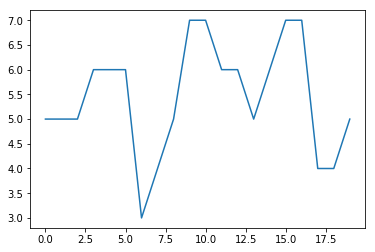

In [11]:
plt.plot(r_theta)
print(np.mean(r_theta))

In [12]:
R_0_list = np.array(R_0_list)
R_0 = np.mean(R_0_list)
print(R_0_list)
print(R_0)

[1.05487043e-08 1.06239040e-08 1.04221659e-08 1.04560592e-08
 1.03625859e-08 1.02510186e-08 1.03625859e-08 1.06405428e-08
 1.04729648e-08 1.04560592e-08 1.02854759e-08 1.05821924e-08
 1.06903040e-08 1.04391263e-08 1.03625859e-08 1.01556582e-08
 1.03625859e-08 1.02682617e-08 9.95331643e-09 9.97994149e-09
 9.97994149e-09 9.96219936e-09 1.00769649e-08 1.00769649e-08
 9.78300849e-09 9.96219936e-09 9.60047364e-09 9.93552676e-09
 1.02682617e-08 1.00945053e-08 1.01120153e-08 1.04391263e-08
 1.00505968e-08 1.02682617e-08 9.94442557e-09 1.02077834e-08
 9.56354860e-09 9.78300849e-09 9.76490855e-09 9.70129283e-09
 9.88196557e-09 9.97994149e-09 1.02337464e-08 1.01382236e-08
 9.97994149e-09 1.02337464e-08 9.99765214e-09 9.97994149e-09
 1.00593938e-08 9.80107500e-09 1.01730629e-08 1.03026613e-08
 1.03966734e-08 1.01469446e-08 1.05235184e-08 1.02940722e-08
 1.07068397e-08 1.04814073e-08 1.04982720e-08 1.04814073e-08
 1.02423861e-08 1.01469446e-08 1.04051779e-08 1.05235184e-08
 1.09033119e-08 1.055708

In [13]:
R_mean_list = np.array(R_mean_list)
R_mean = np.mean(R_mean_list)
print(R_mean_list)
print(R_mean)

[5.55       5.6        5.5        5.5        5.45       5.4
 5.45       5.6        5.5        5.5        5.4        5.55
 5.6        5.5        5.45       5.35       5.45       5.4
 5.2        5.25       5.25       5.25       5.3        5.3
 5.15       5.25       5.05       5.2        5.4        5.3
 5.3        5.5        5.25       5.4        5.25       5.35
 5.05       5.15       5.15       5.1        5.2        5.25
 5.4        5.35       5.25       5.4        5.25       5.25
 5.3        5.15       5.35       5.4        5.45       5.3
 5.5        5.35       5.6        5.45       5.45       5.45
 5.35       5.3        5.4        5.5        5.7        5.5
 5.65       5.4        5.5        5.35       5.35       5.25
 5.5        5.35       5.35       5.4        5.4        5.5
 5.45       5.35       5.25       5.3        5.4        5.5
 5.6        5.35       5.4        5.28571429 5.33333333 5.5
 5.52380952 5.5        5.5        5.55       5.35       5.35
 5.5        5.4        5.25      

In [14]:
r_q_pow_ar = np.array(r_q_pow_list)
print(r_q_pow_ar.shape)
print(r_q_pow_ar)

(11, 333)
[[1.21603396e+03 1.23804318e+03 1.19422213e+03 ... 1.21603396e+03
  1.17260770e+03 1.17260770e+03]
 [4.73595907e-02 3.93735869e-01 2.32346119e-01 ... 4.79597097e+00
  1.23530091e+00 3.47270686e+00]
 [4.45912081e+00 4.23292961e+00 4.23292961e+00 ... 4.49131921e+00
  4.82510587e+00 2.81898660e+00]
 ...
 [3.07088416e-01 2.78289299e-01 5.20980930e-02 ... 1.22205106e+00
  8.52666729e-01 1.06297053e-01]
 [4.22821654e-01 9.12611679e-01 1.59078062e+00 ... 9.22332841e-02
  1.21846327e-01 1.51969358e+00]
 [8.88264396e-01 0.00000000e+00 0.00000000e+00 ... 8.88264396e-01
  9.86960440e-02 9.86960440e-02]]


In [15]:
r_q_pow_ave = np.zeros(lq)
print(r_q_pow_ave)

for i in range(lq):
    r_q_pow_ave[i]=np.mean(r_q_pow_ar[i])

print(r_q_pow_ave)
print(r_q_pow_ave.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.17052145e+03 3.03247983e+00 5.03425040e+00 2.32980940e+00
 1.75436874e+00 1.06922950e+00 1.21225609e+00 7.14637863e-01
 7.56507293e-01 7.24658309e-01 6.49834355e-01]
(11,)


In [16]:
power_sp = r_q_pow_ave * 1/R_mean**2 # R_mean en unités de delta_r
print(power_sp)

[3.95558366e+01 1.02477641e-01 1.70124167e-01 7.87320558e-02
 5.92859903e-02 3.61328426e-02 4.09661900e-02 2.41500047e-02
 2.55649129e-02 2.44886292e-02 2.19600774e-02]


In [17]:
np.save(path_res+'power_sp'+name+'.npy', power_sp)

In [18]:
l_ave = np.load(path_res+'power_sp'+name+'.npy')
print(q)
print(np.shape(q))
print(np.shape(l_ave))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
(11,)
(11,)


Text(0,0.5,'$<|r(q)|²>$')

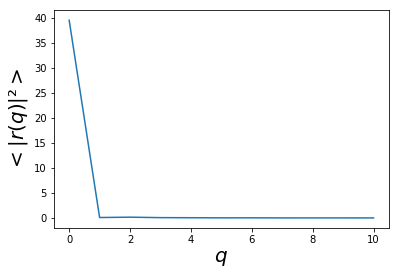

In [19]:
plt.plot(l_ave)

plt.xlabel('$q$',fontsize=20)
plt.ylabel('$<|r(q)|²>$',fontsize=20)

Text(0,0.5,'$q⁴ <|r(q)|²>$')

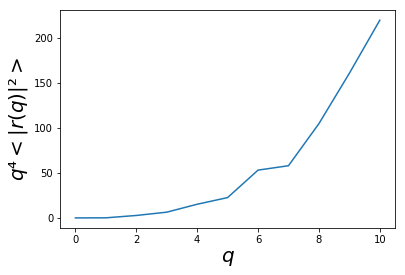

In [20]:
plt.plot(l_ave*q**4)

plt.xlabel('$q$',fontsize=20)
plt.ylabel('$q⁴ <|r(q)|²>$',fontsize=20)

In [21]:
qmin = 2
qmax = 6
q2inv = 1/(q[qmin:qmax]**2-1)
print(q2inv)
varq = l_ave[qmin:qmax]

[0.33333333 0.125      0.06666667 0.04166667]


Text(0,0.5,'$<|r(q)|²>$')

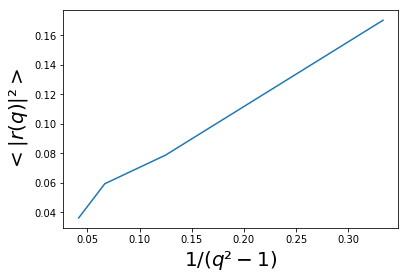

In [22]:
plt.plot(q2inv,varq)

plt.xlabel('$1/(q²-1)$',fontsize=20)
plt.ylabel('$<|r(q)|²>$',fontsize=20)

In [23]:
R_mean_real = R_mean*delta_r # en m
print(R_mean_real)

1.0232298391248392e-08


[0.02353604 0.44140745]


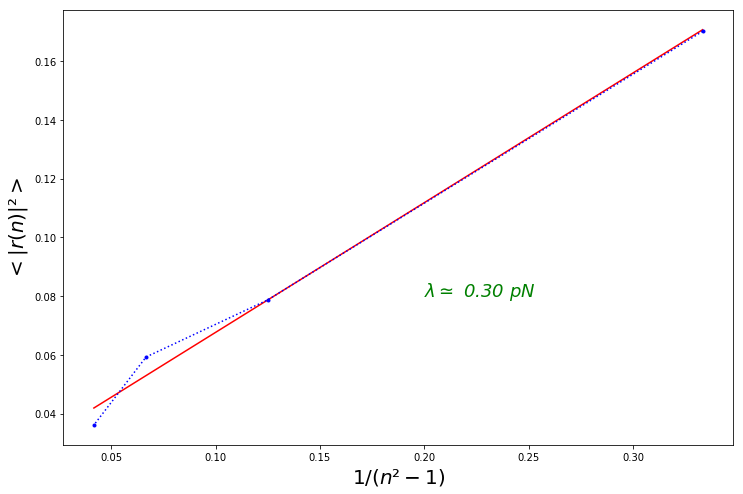

In [24]:
from numpy.polynomial import polynomial as P
pi = np.pi
fig, ax = plt.subplots(figsize=(12, 8))

pfit = P.polyfit(q2inv, varq, 1)
print(pfit)

ax.plot(q2inv, pfit[1]*q2inv+pfit[0], 'red')
ax.plot(q2inv, varq, ':b.')


lamb = 1.38*10**(-23)*310/pi/R_0/pfit[1]*10**(12)



plt.xlabel('$1/(n²-1)$',fontsize=20)
plt.ylabel('$<|r(n)|²>$',fontsize=20)

plt.annotate('$\lambda \simeq$ %.2f pN' % lamb, color='g', fontsize=18, style='italic', xy=(0.2,0.08), xytext=(0.2,0.08))

params = f'_r{nb_r}_theta{nb_theta}_stack{max_frame_stack}_tmes_{tmes}_qmax{qmax}'
plt.savefig(path_res+'line_tension'+name+params+'.pdf', format='pdf',bbox_inches='tight')